## Building a Convoluted Neural Network (CNN) to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

## Load Required Libraries

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
    
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load Data

In [2]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [3]:
num_train, img_channels, img_rows, img_cols =  x_train.shape
num_test, _, _, _ =  x_test.shape
num_classes = len(np.unique(y_train))

## Show an Example From Each Class

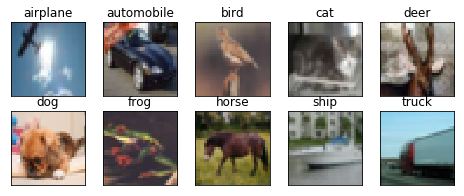

In [4]:
# Each image is a 32 x 32 x 3 numpy array
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::], (1, 2, 0))
    ax.set_title(class_names[i])
    plt.imshow(im)
    
plt.show()

## Data Preprocessing

In [5]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [6]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the 9th position
y_train[444]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [7]:
# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 16, 16)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 6, 6)          25632     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 6, 6)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 3, 3)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 3, 3)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

We still have 181K parameters, even though this is a "small" model.


In [8]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_info = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=15,
                        validation_data=(x_test, y_test),
                        shuffle=True, verbose=0)

In [9]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [10]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

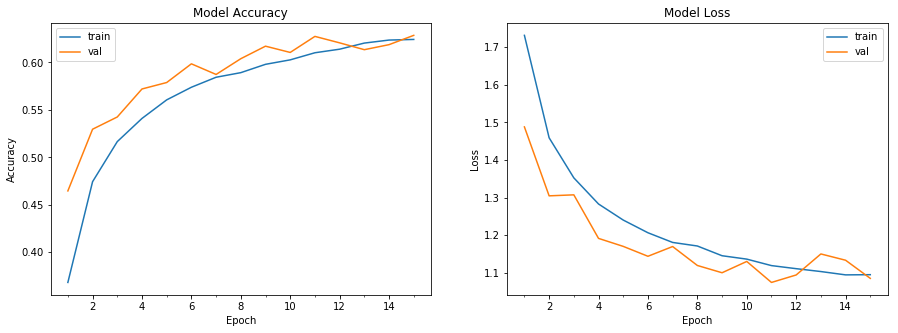

Accuracy on test data is: 62.85


In [11]:
plot_model_history(model_info)
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model_1))

## Second CNN

Our previous model had the structure:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

Let's build a more complicated model with the following pattern:
- Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification
- Using strides of 1 for all convolutional layers.

In [12]:
model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), strides = (1,1), padding='same',
                 input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(32, (5, 5), strides = (1,1), padding='same',
                 input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [13]:
batch_size = 32
opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_2_info = model_2.fit(x_train, y_train,
                           batch_size=batch_size,
                           epochs=5,
                           validation_data=(x_test, y_test),
                           shuffle=True, verbose=0)

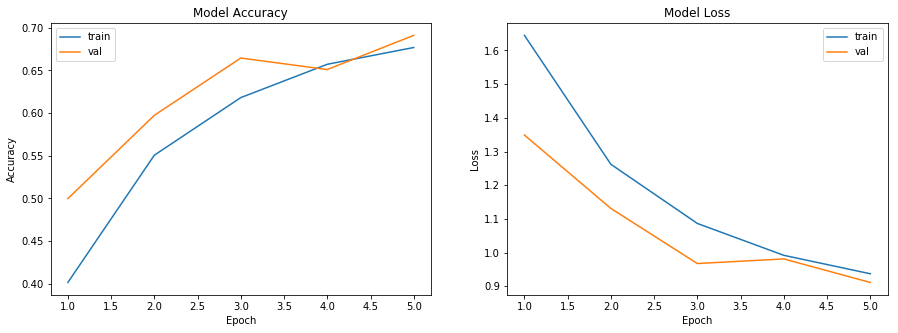

Accuracy on test data is: 69.12


In [14]:
plot_model_history(model_2_info)
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model_2))

The addition of an additional two convolution layers and an associated maximum pooling layer did increase the accuracy from approximately 60% to 70%. Moreover, the increase in validation accuracy and decrease in validation loss appear to be less erratic. A more complicated model is necessary to reach a test accuracy of at least 85%. Such a model is shown below but should only be run when computing resources are sufficient.

## Third CNN

In [15]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

In [16]:
execute_flag = 0

In [18]:
# Define the model
model_3 = Sequential()

model_3.add(Conv2D(48, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_3.add(Activation('relu'))

model_3.add(Conv2D(48, (3, 3)))
model_3.add(Activation('relu'))

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(96, (3, 3), padding='same'))
model_3.add(Activation('relu'))

model_3.add(Conv2D(96, (3, 3)))
model_3.add(Activation('relu'))

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(192, (3, 3), padding='same'))
model_3.add(Activation('relu'))

model_3.add(Conv2D(192, (3, 3)))
model_3.add(Activation('relu'))

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(256))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
if execute_flag == 1:
    model_3_info = model.fit(x_train, y_train,
                             batch_size=128, nb_epoch=200,
                             validation_data = (x_test, y_test),
                             verbose=0)